## Reproductible fitting

In [103]:
from typing import Any, cast

import catppuccin
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import torch

mpl.style.use(catppuccin.PALETTE.latte.identifier)  # type: ignore

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

mpl.rcParams["text.color"] = "black"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["xtick.labelcolor"] = "black"
mpl.rcParams["ytick.labelcolor"] = "black"

In [63]:
torch.manual_seed(42)  # type: ignore


TAU = 6.0


def reg(t: torch.Tensor, psi: torch.Tensor):
    b, w1, w2 = psi.chunk(3, dim=-1)  # Extract relevant terms

    # psi has shape (n_chains, n_individuals, n_repetitions)
    return (b + w1 * t + (w2 - w1) * (t > TAU) * (t - TAU)).unsqueeze(-1)


def link(t: torch.Tensor, psi: torch.Tensor):
    b, w1, w2 = psi.chunk(3, dim=-1)

    diff = (w2 - w1) * (t > TAU)
    val = b + w1 * t + diff * (t - TAU)
    der = w1 + diff
    return torch.cat([val.unsqueeze(-1), der.unsqueeze(-1)], dim=-1)


def random_far_apart(
    n: int, m: int, a: torch.Tensor, b: torch.Tensor, min_dist: torch.Tensor
):
    L_free = (b - a) - (m - 1) * min_dist

    y = torch.rand(n, m) * L_free
    y, _ = torch.sort(y, dim=1)

    gap_offset = torch.arange(m) * min_dist

    return a + y + gap_offset

In [64]:
from jmstate import Exponential, ModelDesign, gamma_plus_b

# Survival model specification
surv = {
    (0, 1): (Exponential(0.1), link),
    (0, 2): (Exponential(0.01), link),
    (1, 2): (Exponential(0.2), link),
}

# Model design gathers regression, link and hazard functions
model_design = ModelDesign(gamma_plus_b, reg, surv)

In [ ]:
def plot_history(
    vals: list[torch.Tensor], true_val: torch.Tensor, name: str, colors: list[Any]
):
    plt.plot(torch.cat(vals, dim=0))  # type: ignore

    for i, t in enumerate(true_val):
        plt.axhline(  # type: ignore
            y=t.item(),
            color=colors[i],
            linestyle="--",
            label=(
                f"True value of {name}" + (f"({i + 1})" if true_val.numel() > 1 else "")
            ),
        )

    plt.title(f"Stochastic optimization of the parameter {name}.")  # type: ignore
    plt.legend()  # type: ignore
    plt.xlabel("Iteration")  # type: ignore
    plt.ylabel("Value")  # type: ignore
    plt.tight_layout()
    plt.savefig(f"figures/{name}-multi.png")  # type: ignore
    plt.show()  # type: ignore


def param_names(params_dict: dict[Any, Any]) -> list[str]:
    names: list[str] = []

    def _rec(node: dict[Any, Any] | torch.Tensor, prefix: list[Any]):
        if isinstance(node, torch.Tensor):
            base_name = str(prefix[0]) + "".join(f"[{item}]" for item in prefix[1:])
            num_elements = node.numel()
            if num_elements <= 1:
                names.append(base_name)
            else:
                names.extend(f"{base_name}[{i + 1}]" for i in range(num_elements))
        else:
            for k, v in node.items():
                prefix.append(k)
                _rec(v, prefix)
                prefix.pop()

    _rec(params_dict, [])

    return names

In [66]:
from jmstate import ModelParams, repr_from_cov

# Gaussian means
gamma = torch.tensor([2.5, -1.3, 0.2])

# Covariance matrices
Q = torch.diag(torch.tensor([0.6, 0.2, 0.3]))
R = torch.tensor([[1.7]])

# Link parameters
alphas = {
    (0, 1): torch.tensor([-0.5, -3.0]),
    (0, 2): torch.tensor([-1.0, -5.0]),
    (1, 2): torch.tensor([0.0, -1.2]),
}

# Covariate parameters
betas = {
    (0, 1): torch.tensor([-1.3]),
    (0, 2): torch.tensor([-0.9]),
    (1, 2): torch.tensor([-0.7]),
}

# Instance declaration
real_params = ModelParams(
    gamma,
    repr_from_cov(Q, method="diag"),
    repr_from_cov(R, method="ball"),
    alphas,
    betas,
)

In [67]:
from torch.distributions import MultivariateNormal

from jmstate import ModelData, MultiStateJointModel, SampleData

# Declare the true underlying model
real_model = MultiStateJointModel(model_design, real_params)


def gen_data(n: int, m: int):
    # Censoring times
    c = torch.rand(n, 1) * 5 + 10

    # Covariates
    x = torch.randn(n, 1)

    # Latent and noise distributions
    Q_dist = MultivariateNormal(torch.zeros(Q.size(0)), Q)
    R_dist = MultivariateNormal(torch.zeros(R.size(0)), R)

    # Individual effects
    b = Q_dist.sample((n,))
    psi = model_design.individual_effects_fn(gamma, x, b)

    # Generates random evaluations points with a minimum distance
    a = torch.zeros((n, 1))
    b = torch.full((n, 1), 15)
    t = random_far_apart(n, m, a, b, 0.7 * b / m)

    # Define initial state for individuals
    trajectories_init = [[(0.0, 0)]] * n

    # Sample trajectories
    sample_data = SampleData(x, trajectories_init, psi)
    trajectories = real_model.sample_trajectories(sample_data, c)

    # Sample longitudinal values
    y = model_design.regression_fn(t, psi)
    y += R_dist.sample(y.shape[:2])

    # Censor longitudinal measurements exceeding censoring times
    y[t > c] = torch.nan

    return x, t, y, trajectories, c


# Generate data
data = ModelData(*gen_data(1000, 20))

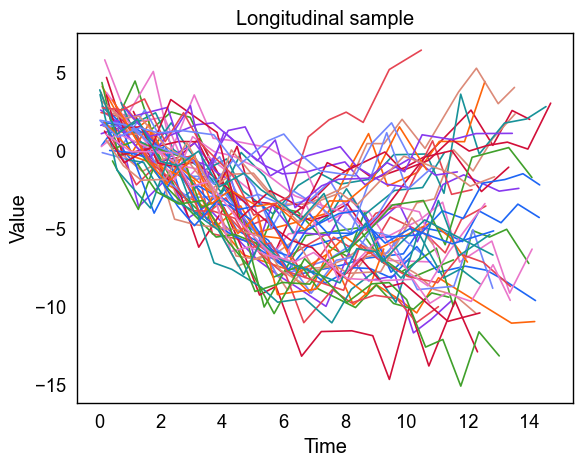

In [105]:
plt.plot(data.t[:50].T, data.y[:50].squeeze(-1).T)  # type: ignore
plt.title("Longitudinal sample")  # type: ignore
plt.xlabel("Time")  # type: ignore
plt.ylabel("Value")  # type: ignore
plt.savefig("figures/longitudinal_sample-multi.png")  # type: ignore
plt.show()  # type: ignore

In [69]:
from jmstate import build_buckets

buckets = build_buckets(data.trajectories)
print({key: val.idxs.numel() for key, val in buckets.items()})

{(0, 2): 375, (0, 1): 613, (1, 2): 592}


In [70]:
# Declare initial parameters; zero mean and unit variance
init_params = ModelParams(
    torch.zeros_like(gamma),
    repr_from_cov(torch.eye(Q.size(0)), method="diag"),
    repr_from_cov(torch.eye(R.size(0)), method="ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

In [71]:
from jmstate import Fit, LogParamsHistory, MultiStateJointModel, ParamStop

# Declare initial model
model = MultiStateJointModel(model_design, init_params)

# Run optimization process
metrics = model.do(
    data,
    job_factories=[
        Fit(lr=0.5, fused=True),
        ParamStop(rtol=0.1),
        LogParamsHistory(),  # Returns a list of ModelParams
    ],
    max_iterations=500,
)

Running joint model:  52%|█████▏    | 260/500 [00:22<00:20, 11.57it/s]


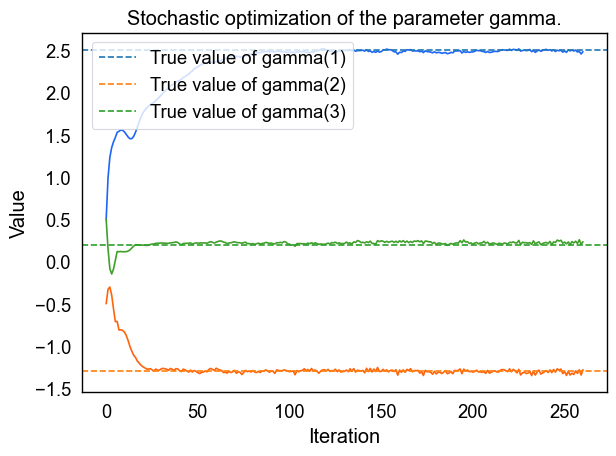

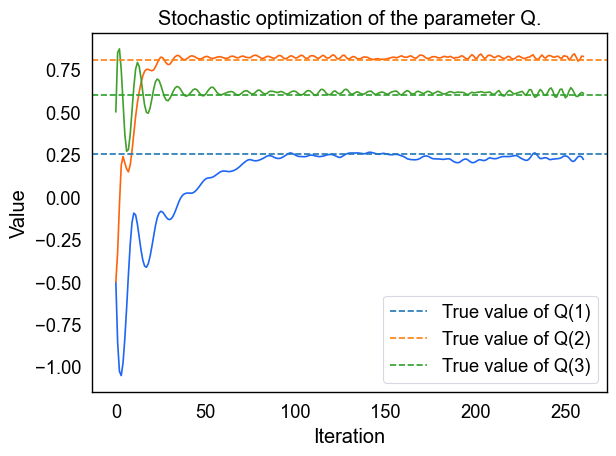

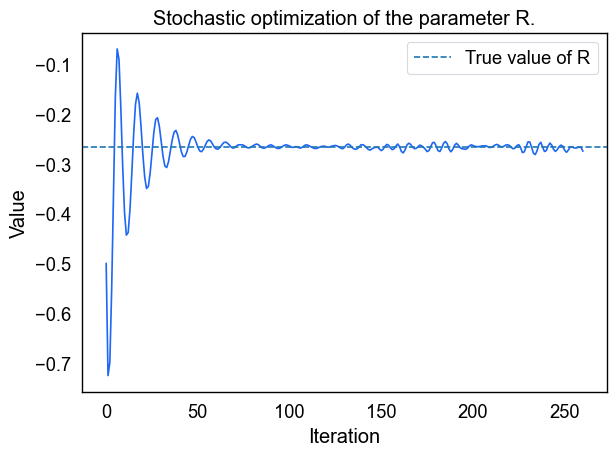

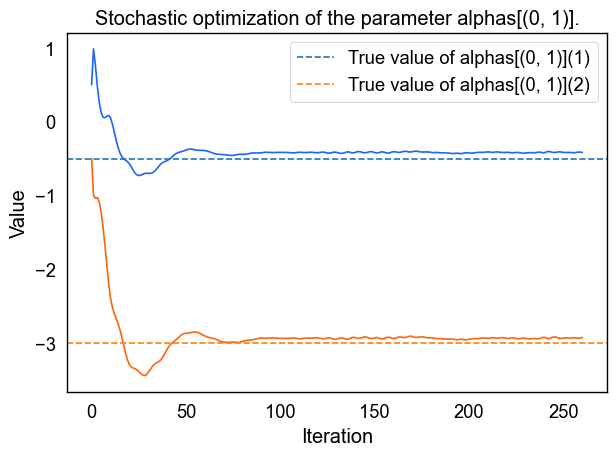

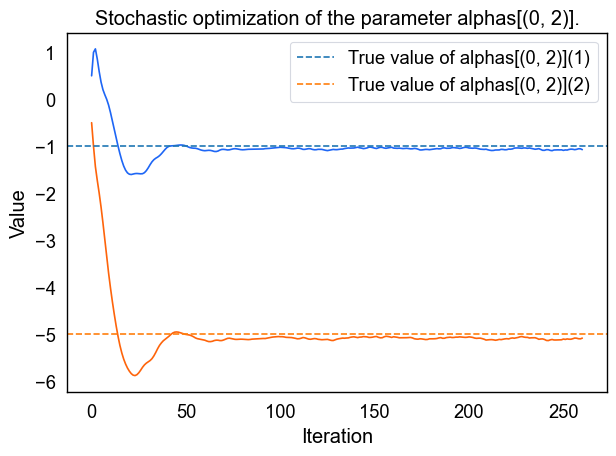

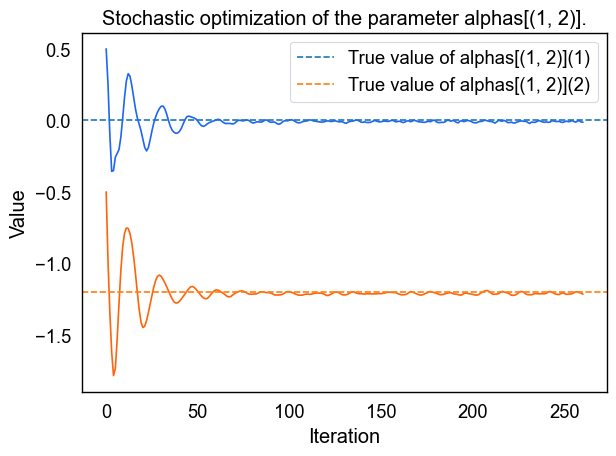

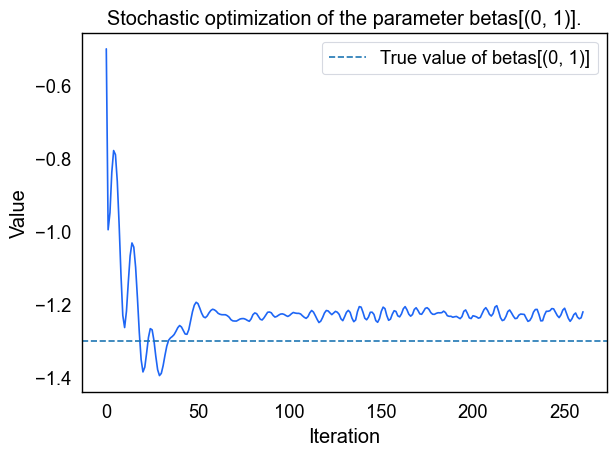

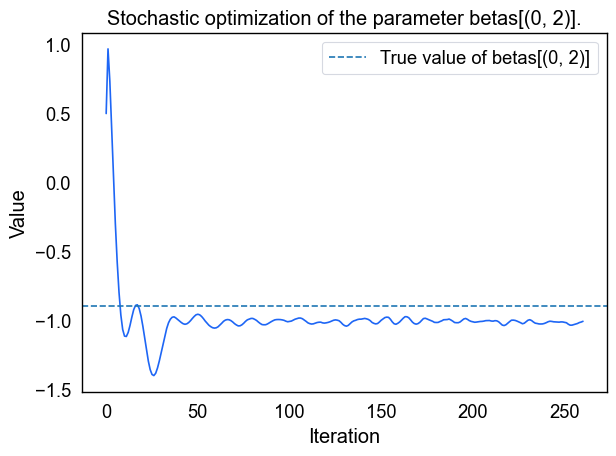

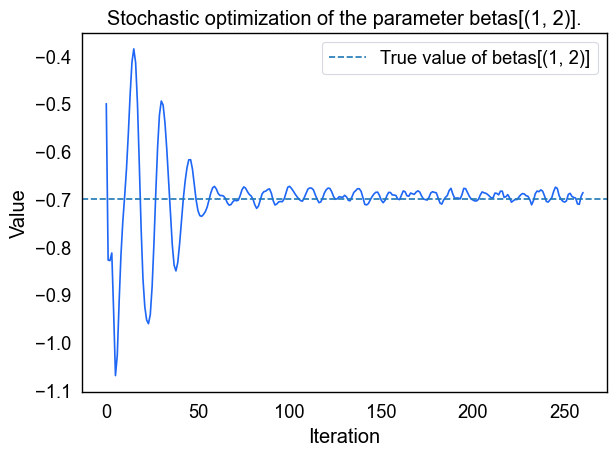

In [104]:
params_dict = model.params_.as_dict
real_params_dict = real_model.params_.as_dict
colors: list[Any] = cast(list[Any], plt.get_cmap("tab10").colors)  # type: ignore

for key, val in params_dict.items():
    if isinstance(val, torch.Tensor):
        history = [
            cast(torch.Tensor, p.as_dict[key])[None]
            for p in cast(list[ModelParams], metrics)
        ]
        plot_history(history, cast(torch.Tensor, real_params_dict[key]), key, colors)
    else:
        for subkey in val:
            history = [p.as_dict[key][subkey][None] for p in metrics]  # type: ignore
            plot_history(
                history,  # type: ignore
                real_params_dict[key][subkey],
                key + f"[{subkey}]",
                colors,
            )

In [52]:
params_list: list[torch.Tensor] = []
n_runs = 100

for _ in range(n_runs):
    data = ModelData(*gen_data(1000, 20))

    model = MultiStateJointModel(model_design, init_params)
    model.do(
        data,
        job_factories=[Fit(lr=0.5, fused=True), ParamStop(rtol=0.1)],
        max_iterations=500,
    )

    params_list.append(model.params_.as_flat_tensor.view(1, -1))

Running joint model:  51%|█████     | 255/500 [00:21<00:20, 12.10it/s]


In [53]:
names = param_names(real_model.params_.as_dict)

stacked_params = torch.cat(params_list, dim=0)
mean = stacked_params.mean(dim=0)
std = stacked_params.std(dim=0)
rmse = (std**2 + (mean - real_model.params_.as_flat_tensor) ** 2).sqrt()

data = {
    "True parameters": real_model.params_.as_flat_tensor.numpy(),
    "Mean of inferred parameters": mean.numpy(),
    "Std of inferred parameters": std.numpy(),
    "RMSE of inferred parameters": rmse.numpy(),
}

index = [f"{names[i]}" for i in range(mean.size(0))]

df = pd.DataFrame(data, index=index)
pd.set_option("display.float_format", "{:.4e}".format)

print(df)

                   True parameters  Mean of inferred parameters  \
gamma[1]                2.5000e+00                   2.4960e+00   
gamma[2]               -1.3000e+00                  -1.3039e+00   
gamma[3]                2.0000e-01                   1.9356e-01   
Q[1]                    2.5541e-01                   2.2432e-01   
Q[2]                    8.0472e-01                   8.0093e-01   
Q[3]                    6.0199e-01                   6.0014e-01   
R                      -2.6531e-01                  -2.6837e-01   
alphas[(0, 1)][1]      -5.0000e-01                  -4.9997e-01   
alphas[(0, 1)][2]      -3.0000e+00                  -2.9962e+00   
alphas[(0, 2)][1]      -1.0000e+00                  -9.9904e-01   
alphas[(0, 2)][2]      -5.0000e+00                  -4.9897e+00   
alphas[(1, 2)][1]       0.0000e+00                   1.0636e-03   
alphas[(1, 2)][2]      -1.2000e+00                  -1.2045e+00   
betas[(0, 1)]          -1.3000e+00                  -1.3015e+0